
# 2. Model Development

### i. Experiment Tracking with Weights and Biases

In [1]:
import wandb
import os
import sklearn

In [2]:
os.environ["WANDB_API_KEY"] = "c1dd26a5e3acf8ba7bdf09cf890e948c409d1f44"

In [3]:
def run_model_experiment(model,
                         x_train,
                         y_train,
                         x_test,
                         y_test,
                         name,
                         config = None,
                         tags = None):
  
  model.fit(x_train, y_train)

  wandb.init(project='CreditChurn', config=config, tags = tags)
  wandb.run.name = name
  
  y_pred = model.predict(x_test)  
  y_prob = model.predict_proba(x_test) 
  
  acc = sklearn.metrics.accuracy_score(y_pred,y_test)
  precision = sklearn.metrics.precision_score(y_pred,y_test) 
  recall = sklearn.metrics.recall_score(y_pred,y_test)
  f1_score = sklearn.metrics.f1_score(y_pred,y_test)  

  wandb.log( {"accuracy" : acc,
             "precision": precision,
             "recall":recall,
             "f1_score":f1_score} )
  
  # ROC
  wandb.log({"roc" : wandb.plot.roc_curve(y_test, y_prob,model.classes_)})

  # PR
  wandb.log({"pr" : wandb.plot.pr_curve(y_test, y_prob, model.classes_)})
    
  # Confusion Matrices
  wandb.sklearn.plot_confusion_matrix(y_test, y_pred, labels= model.classes_)
  
  wandb.Artifact(name, 
                 type = 'model',
                 description = config)
 

  wandb.save()
  wandb.finish()

  return model

### Loading Datasets

In [4]:
import pandas as pd
import numpy as np

In [5]:
churn_train = pd.read_pickle('https://github.com/apollo-robin/customer-churn/raw/main/DataFiles/processed/churn_train.pkl')
churn_test = pd.read_pickle('https://github.com/apollo-robin/customer-churn/raw/main/DataFiles/processed/churn_test.pkl')

In [6]:
churn_train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,35,F,2,Graduate,Married,Less than $40K,Blue,36,5,2,4,5546.0,1829,3717.0,0.673,1770,46,1.000,0.330,0
1,57,F,1,Uneducated,Single,Less than $40K,Blue,46,2,3,3,9129.0,0,9129.0,0.733,7733,81,0.884,0.000,1
2,59,F,1,Graduate,Single,Less than $40K,Blue,52,5,3,3,2636.0,1619,1017.0,0.565,4727,83,0.627,0.614,0
3,45,F,4,Graduate,Single,Less than $40K,Blue,33,2,1,3,3001.0,2055,946.0,0.838,4662,70,0.628,0.685,0
4,43,M,2,Doctorate,Single,$120K +,Blue,34,5,3,4,33913.0,0,33913.0,0.901,4160,76,0.900,0.000,0


In [7]:
X_train = churn_train.drop('Attrition_Flag',axis = 1)
X_test = churn_test.drop('Attrition_Flag',axis = 1)

y_train = churn_train['Attrition_Flag']
y_test = churn_test['Attrition_Flag']

## 2.1 Encoding Variables 

In [8]:
cat_features = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
cat_features

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [9]:
num_features = list(set(X_train.columns) - set(cat_features))
num_features

['Total_Ct_Chng_Q4_Q1',
 'Total_Relationship_Count',
 'Total_Revolving_Bal',
 'Months_on_book',
 'Total_Trans_Ct',
 'Contacts_Count_12_mon',
 'Customer_Age',
 'Total_Amt_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Avg_Open_To_Buy',
 'Total_Trans_Amt',
 'Months_Inactive_12_mon',
 'Credit_Limit',
 'Dependent_count']

### 2.1.1 Categorical Variables 

#### One Hot Encoding

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
ohe_encoder = OneHotEncoder()

In [12]:
ohe_features = ['Gender','Marital_Status']
ohe_features

['Gender', 'Marital_Status']

#### Target Encoding

In [13]:
from category_encoders import TargetEncoder

In [14]:
target_encoder = TargetEncoder(min_samples_leaf=100,
                               smoothing= 10000)

In [15]:
te_features = list(set(cat_features) - set(ohe_features))
te_features

['Income_Category', 'Card_Category', 'Education_Level']

### 2.1.2 Numerical Variables 

#### Feature Binning

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

In [17]:
binner = KBinsDiscretizer(n_bins=5,
                          encode='ordinal',
                          strategy='uniform')

In [18]:
bin_features = ['Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Trans_Amt']
bin_features

['Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Trans_Amt']

#### Standard Scaler

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()

In [21]:
scale_features = list(set(num_features) - set(bin_features))
scale_features 

['Total_Ct_Chng_Q4_Q1',
 'Total_Relationship_Count',
 'Months_on_book',
 'Total_Trans_Ct',
 'Contacts_Count_12_mon',
 'Customer_Age',
 'Total_Amt_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Months_Inactive_12_mon',
 'Dependent_count']

### 2.1.3 Column Transformer

In [22]:
from sklearn.compose import ColumnTransformer

In [23]:
preprocessor = ColumnTransformer(transformers=[
                                                ('ohe',ohe_encoder, ohe_features),
                                                ('te',target_encoder,te_features),
                                                ('bin',binner,bin_features),
                                                ('scaler',scaler,scale_features)],
                                                 remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(),
                                 ['Gender', 'Marital_Status']),
                                ('te',
                                 TargetEncoder(min_samples_leaf=100,
                                               smoothing=10000.0),
                                 ['Income_Category', 'Card_Category',
                                  'Education_Level']),
                                ('bin',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['Credit_Limit', 'Total_Revolving_Bal',
                                  'Avg_Open_To_Buy', 'Total_Trans_Amt']),
                                ('scaler', StandardScaler(),
                                 ['Total_Ct_Chng_Q4_Q1',
                                  'Total_Relationship_Count', 'Months_on_book',
            

## 2.2 Classification Models 

In [24]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

### 2.2.1 Logistic Regression

In [25]:
# Logistic Regression Classifier
lr = LogisticRegression(max_iter= 1000)

# Pipeline 
lr_clf = Pipeline(steps=[('pre', preprocessor),
                          ('lr',lr)])

In [26]:
lr_clf = run_model_experiment(lr_clf,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "LogisiticRegression",
                             config = None,
                             tags = None)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: apollo101 (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.85256
f1_score,0.63733
precision,0.78358
recall,0.53708


In [27]:
lr_clf.score(X_test,y_test)

0.8525601480567551

### 2.2.2 Decision Trees

In [28]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier()

params_dt = {'dt__max_depth': [2, 3, 5, 10, 20],
            'dt__min_samples_leaf': [5, 10, 20, 50, 100],
            'dt__criterion': ["gini", "entropy"]}

# Pipeline 
dt_pipe = Pipeline(steps=[('pre', preprocessor),
                          ('dt',dt)])

#Grid Search
dt_clf = GridSearchCV(estimator = dt_pipe, 
                       param_grid = params_dt, 
                       cv = 5, verbose=2, 
                       n_jobs = -1)

In [29]:
dt_clf = run_model_experiment(dt_clf,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "DecisionTrees",
                             config = None,
                             tags = None)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.88526
f1_score,0.68687
precision,0.76119
recall,0.62577


In [30]:
dt_clf.best_params_

{'dt__criterion': 'entropy', 'dt__max_depth': 20, 'dt__min_samples_leaf': 5}

In [31]:
dt_clf.score(X_test,y_test)

0.8852560148056755

### 2.2.3 kNN

In [32]:
# Create k Nearest Neighbor classifer object
knn = KNeighborsClassifier()

params_knn = {'knn__n_neighbors': [5,10,15,20,25],
            'knn__weights': ['uniform','distance'],
            'knn__leaf_size': [10,20,30,40,50]}

# Pipeline 
knn_pipe = Pipeline(steps=[('pre', preprocessor),
                          ('knn',knn)])


#Grid Search
knn_clf = GridSearchCV(estimator = knn_pipe, 
                       param_grid = params_knn, 
                       cv = 5, verbose=2, 
                       n_jobs = -1)

In [33]:
knn_clf = run_model_experiment(knn_clf,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "KNN",
                             config = None,
                             tags = None)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.87785
f1_score,0.69444
precision,0.83955
recall,0.59211


In [34]:
knn_clf.best_params_

{'knn__leaf_size': 10, 'knn__n_neighbors': 10, 'knn__weights': 'uniform'}

In [35]:
knn_clf.score(X_test,y_test)

0.8778531770512029

### 2.2.4 Random Forest

In [36]:
#Create a Random Forest Classifier
rf = RandomForestClassifier()

params_rf = {'rf__n_estimators': [100, 200, 300, 400, 500], 
               'rf__max_features': ['auto', 'sqrt'],
               'rf__max_depth': [10, 20, 30, 40, 50]}

rf_pipe = Pipeline(steps=[('pre',preprocessor),
                         ('rf',rf)])

#Grid Search
rf_clf = GridSearchCV(estimator = rf_pipe, 
                       param_grid = params_rf, 
                       cv = 5, verbose=2, 
                       n_jobs = -1)

In [37]:
rf_clf = run_model_experiment(rf_clf,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "RandomForest",
                             config = None,
                             tags = None)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.9235
f1_score,0.77698
precision,0.80597
recall,0.75


In [38]:
rf_clf.best_params_

{'rf__max_depth': 50, 'rf__max_features': 'auto', 'rf__n_estimators': 500}

In [39]:
rf_clf.score(X_test,y_test)

0.9235040098704503

### 2.2.5 XG Boost

In [40]:
xg =   xgboost.XGBClassifier(use_label_encoder = False)

params_xg = {'xg__gamma': [0.5, 1, 1.5, 2],
        'xg__subsample': [0.6, 0.8, 1.0],
        'xg__max_depth': [4,6,10,12,15],
        'xg__eval_metric':['logloss']}

xg_pipe = Pipeline(steps=[('pre',preprocessor),
                          ('xg',xg)])

#Grid Search
xg_clf = GridSearchCV(estimator = xg_pipe, 
                       param_grid = params_xg, 
                       cv = 5, verbose=2, 
                       n_jobs = -1)


In [41]:
xg_clf = run_model_experiment(xg_clf,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "XGBoost",
                             config = None,
                             tags = None)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.93214
f1_score,0.79853
precision,0.81343
recall,0.78417


In [42]:
xg_clf.best_params_

{'xg__eval_metric': 'logloss',
 'xg__gamma': 0.5,
 'xg__max_depth': 10,
 'xg__subsample': 0.6}

In [43]:
xg_clf.score(X_test,y_test)

0.932140653917335

### 2.2.6 Voting Classifier 

In [44]:
# Top 3 models 
knn_final = KNeighborsClassifier(leaf_size= 10,
                                 n_neighbors= 10,
                                 weights='uniform')

rf_final = RandomForestClassifier(max_depth=20,
                                  max_features= 'auto',
                                  n_estimators= 200)

xg_final = xgboost.XGBClassifier(eval_metric= 'logloss',
                                 gamma= 0.5,
                                 max_depth= 10,
                                 subsample= 0.8,
                                 use_label_encoder = False)


In [45]:
estimators = [('knn', knn_final),
              ('rf', rf_final),
              ('xgb',xg_final)]

In [46]:
voting = VotingClassifier(estimators= estimators,voting= 'soft')

voting_clf = Pipeline(steps=[('pre',preprocessor),
                            ('vote',voting)])

In [47]:
voting_clf = run_model_experiment(voting_clf,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "VotingClassifier",
                             config = None,
                             tags = None)

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.93091
f1_score,0.80142
precision,0.84328
recall,0.76351


In [48]:
voting_clf.score(X_test,y_test)

0.9309068476249229

### 2.2.7 Stacking Classifier

In [49]:
final_estimator = LogisticRegression()

stacking = StackingClassifier(estimators= estimators,
                             final_estimator= final_estimator)

stacking_clf = Pipeline(steps=[('pre',preprocessor),
                              ('stack',stacking)])

In [50]:
stacking_clf = run_model_experiment(stacking_clf,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "StackingClassifier",
                             config = None,
                             tags = None)

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.93337
f1_score,0.80147
precision,0.81343
recall,0.78986


In [51]:
stacking_clf.score(X_test,y_test)

0.933374460209747

## 2.3 Final Model  

XG Boost gave the best accuracy score of 0.93, thus going forward with XG Boost

### Feature Selection

In [52]:
import warnings
import seaborn as sns
import matplotlib.pylab as plt

In [53]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [56]:
xg_final.fit(preprocessor.transform(X_train),y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\robin\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Transformer bin (type KBinsDiscretizer) does not provide get_feature_names. Will return input column names if available
C:\Users\robin\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available


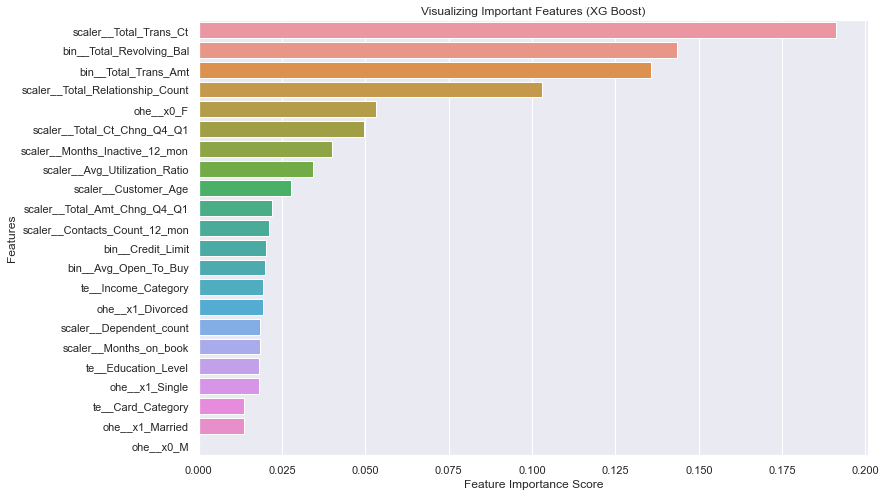

In [58]:
feature_imp = pd.Series(xg_final.feature_importances_,index=get_feature_names(preprocessor)).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
sns.set(rc={'figure.figsize':(12,8)})
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features (XG Boost)")
plt.show()

### Most Important Features

In [59]:
imp_features = ['Total_Trans_Ct','Total_Revolving_Bal','Total_Relationship_Count','Total_Trans_Amt','Gender',
                'Total_Ct_Chng_Q4_Q1','Months_Inactive_12_mon','Avg_Utilization_Ratio','Customer_Age','Total_Amt_Chng_Q4_Q1']

In [60]:
preprocessor2 = ColumnTransformer(transformers=[('ohe',ohe_encoder, ['Gender']),
                                                ('bin',binner,['Total_Revolving_Bal','Total_Trans_Amt']),
                                                ('scaler',scaler,['Total_Trans_Ct','Total_Relationship_Count','Customer_Age',
                                                                 'Total_Ct_Chng_Q4_Q1','Months_Inactive_12_mon',
                                                                  'Avg_Utilization_Ratio','Total_Amt_Chng_Q4_Q1'])],
                                                 remainder='drop')
preprocessor2

ColumnTransformer(transformers=[('ohe', OneHotEncoder(), ['Gender']),
                                ('bin',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['Total_Revolving_Bal', 'Total_Trans_Amt']),
                                ('scaler', StandardScaler(),
                                 ['Total_Trans_Ct', 'Total_Relationship_Count',
                                  'Customer_Age', 'Total_Ct_Chng_Q4_Q1',
                                  'Months_Inactive_12_mon',
                                  'Avg_Utilization_Ratio',
                                  'Total_Amt_Chng_Q4_Q1'])])

In [61]:
xg =   xgboost.XGBClassifier(use_label_encoder = False)

params_xg = {'xg__gamma': [0.5, 1, 1.5, 2],
        'xg__subsample': [0.6, 0.8, 1.0],
        'xg__max_depth': [4,6,10,12,15],
        'xg__eval_metric':['logloss']}

xg_pipe2 = Pipeline(steps=[('pre',preprocessor2),
                          ('xg',xg)])

#Grid Search
xg_top = GridSearchCV(estimator = xg_pipe2, 
                       param_grid = params_xg, 
                       cv = 5, verbose=2, 
                       n_jobs = -1)

In [62]:
xg_top = run_model_experiment(xg_top,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "XGBoostTopFeatures",
                             config = None,
                             tags = "XG Boost")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.92721
f1_score,0.78929
precision,0.82463
recall,0.75685


In [63]:
xg_grid_results = pd.DataFrame(xg_top.cv_results_)

### Using One Standard Error Rule 

In [64]:
highest_score_std = xg_grid_results[xg_grid_results.rank_test_score == 1].iloc[0]['std_test_score']
highest_score_mean = xg_grid_results[xg_grid_results.rank_test_score == 1].iloc[0]['mean_test_score']

In [65]:
highest_score_mean,highest_score_std

(0.9535603421840138, 0.017651743423313115)

In [66]:
std_error = highest_score_std / np.sqrt(10)
one_standard_error = highest_score_mean - std_error
one_standard_error

0.9479783707949571

In [67]:
xg_grid_results[xg_grid_results.mean_test_score > one_standard_error]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xg__eval_metric,param_xg__gamma,param_xg__max_depth,param_xg__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1.115363,0.025443,0.014474,1.162084e-03,logloss,0.5,4,0.8,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.916322,0.952644,0.956322,0.960000,0.964581,0.949974,0.017285,32
3,1.631437,0.039235,0.013953,7.642643e-03,logloss,0.5,6,0.6,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.914023,0.951724,0.954483,0.964598,0.962282,0.949422,0.018329,40
4,1.618551,0.031623,0.012698,6.359611e-03,logloss,0.5,6,0.8,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.916782,0.955402,0.952644,0.966437,0.964121,0.951077,0.017908,21
5,1.451110,0.031701,0.012597,6.051493e-03,logloss,0.5,6,1,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.917701,0.957241,0.957241,0.963218,0.967801,0.952641,0.017916,6
6,2.525307,0.024551,0.021074,1.339930e-02,logloss,0.5,10,0.6,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.919080,0.955862,0.953103,0.961379,0.961362,0.950157,0.015865,31
7,2.633268,0.079704,0.016157,7.076044e-04,logloss,0.5,10,0.8,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.920920,0.953103,0.955402,0.969655,0.968721,0.953560,0.017652,1
8,2.501102,0.065878,0.015354,7.114902e-04,logloss,0.5,10,1,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.918161,0.954023,0.954483,0.965977,0.965961,0.951721,0.017580,14
9,2.919820,0.043213,0.017387,1.964904e-03,logloss,0.5,12,0.6,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.919080,0.954943,0.955402,0.966437,0.965501,0.952273,0.017287,8
10,3.049789,0.039975,0.013959,3.004001e-03,logloss,0.5,12,0.8,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.919540,0.955402,0.954943,0.967816,0.965041,0.952549,0.017278,7
11,3.020342,0.145447,0.014951,1.095276e-03,logloss,0.5,12,1,"{'xg__eval_metric': 'logloss', 'xg__gamma': 0....",0.919540,0.954483,0.960000,0.964598,0.967341,0.953192,0.017382,2


In [68]:
xg_final = xgboost.XGBClassifier(gamma = 0.5,
                                     max_depth = 4,
                                     subsample = 0.8,
                                     eval_metric = 'logloss',
                                     use_label_encoder = False)

In [69]:
final_clf = Pipeline(steps=[('pre',preprocessor2),
                           ('xg',xg_final)])

In [70]:
final_clf = run_model_experiment(final_clf,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "FinalModelClassifierTopFeatures",
                             config = None,
                             tags = "XG Boost")

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.92412
f1_score,0.7823
precision,0.82463
recall,0.74411


In [71]:
final_clf.score(X_test,y_test)

0.9241209130166563

## 2.4 Model Evaluation and Calibration

In [72]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, confusion_matrix
from sklearn.metrics import matthews_corrcoef, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### 2.4.1 Classification Report

In [73]:
final_preds = final_clf.predict(X_test)
print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1353
           1       0.74      0.82      0.78       268

    accuracy                           0.92      1621
   macro avg       0.85      0.88      0.87      1621
weighted avg       0.93      0.92      0.93      1621



### 2.4.2 Confusion Matrix

Text(0.5, 510.88, 'Predicted label')

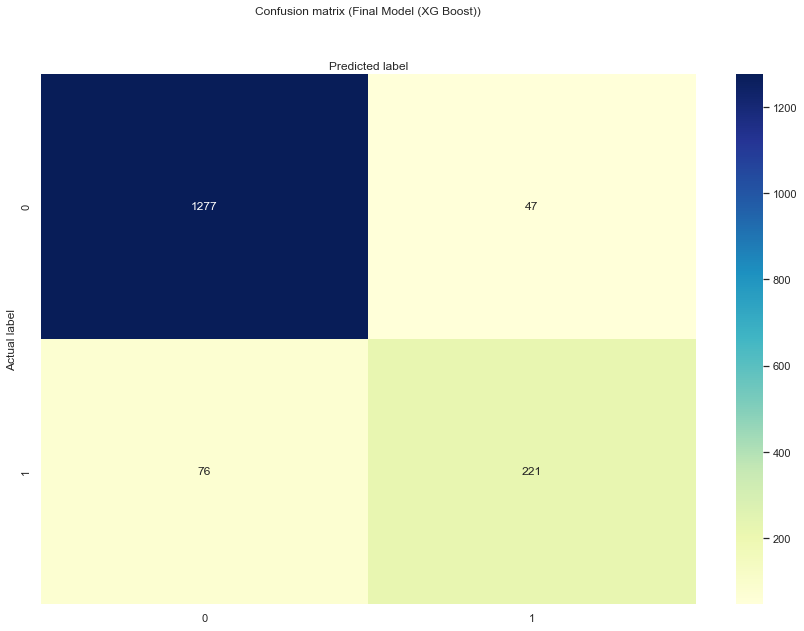

In [74]:
cnf_matrix = confusion_matrix(final_preds,y_test)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix (Final Model (XG Boost))', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### 2.4.3 ROC Curve

Text(0.5, 1.0, 'ROC Curve')

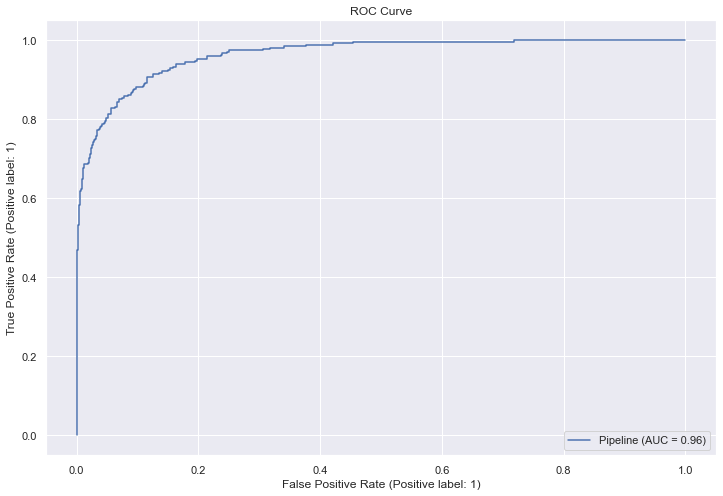

In [76]:
plot_roc_curve(final_clf, X_test, y_test)
plt.title("ROC Curve")

### 2.4.4 PR Curve

Text(0.5, 1.0, 'PR Curve')

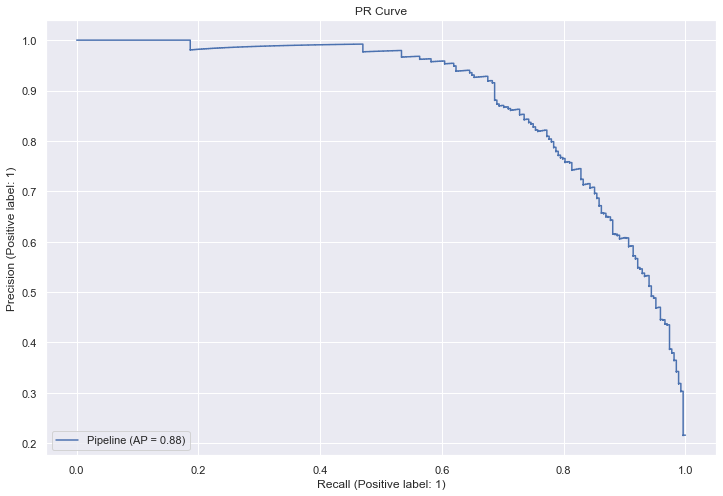

In [77]:
plot_precision_recall_curve(final_clf, X_test, y_test)
plt.title("PR Curve")

### 2.4.5 Matthews Corrleation Coefficient

In [78]:
print("Matthews Correlation:",matthews_corrcoef( y_test, final_preds))

Matthews Correlation: 0.7379258801615464


### 2.4.6 Calibration Curve

In [79]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

In [80]:
final_probs = final_clf.predict_proba(X_test)

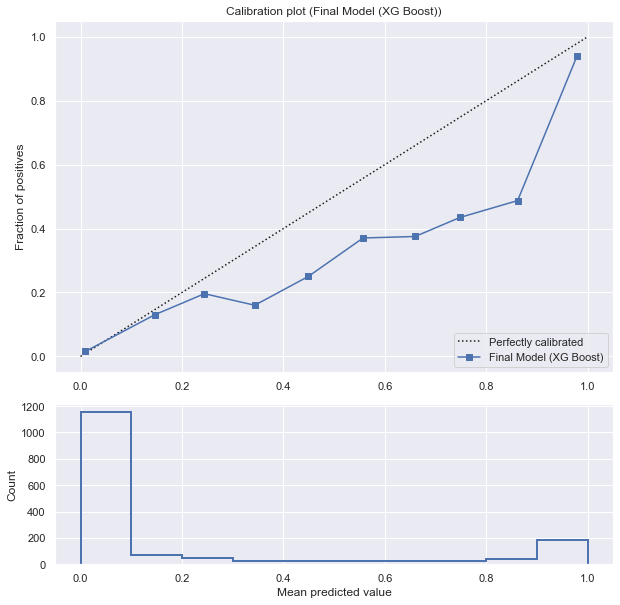

In [81]:
plot_calibration_curve("Final Model (XG Boost)", 1, final_probs[:,1])

In [82]:
from sklearn.calibration import CalibratedClassifierCV

In [83]:
final_calibrated = CalibratedClassifierCV(final_clf, cv=2, method='sigmoid')

final_calibrated = run_model_experiment(final_calibrated,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             name = "FinalModelCalibratedTopFeatures",
                             config = None,
                             tags = "XG Boost")

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.9235
f1_score,0.78322
precision,0.83582
recall,0.73684


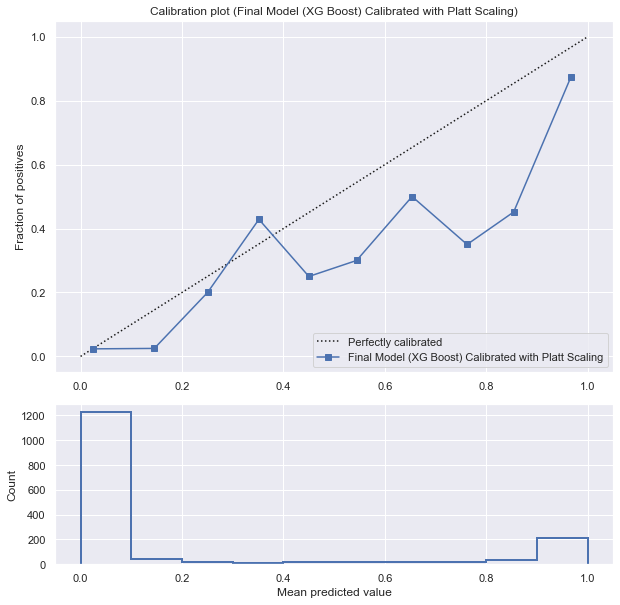

In [84]:
final_calibrated_probs = final_calibrated.predict_proba(X_test)[:,1]

plot_calibration_curve("Final Model (XG Boost) Calibrated with Platt Scaling", 3, final_calibrated_probs)

In [85]:
final_acc = final_clf.score(X_test,y_test)
final_acc

0.9241209130166563

## 2.5 Saving the model

In [86]:
class CreditChurnClassification():
    
    def __init__(self, model, features, acc):
        self.model = model
        self.features = features
        self.acc = acc

In [87]:
my_model = CreditChurnClassification(final_clf, list(X_train.columns), final_acc)

In [88]:
from joblib import dump

In [89]:
dump(my_model, '../Models/Churn_xgb_top.pkl')

['../Models/Churn_xgb_top.pkl']